In [ ]:
import os
from EQTransformer.utils.hdf5_maker import preprocessor
json_basepath = os.path.join(os.getcwd(),"json/station_list.json")
preprocessor(preproc_dir="preproc", mseed_dir='downloads_mseeds', stations_json=json_basepath, overlap=0.3, n_processor=2)


In [1]:
# code in this block is replaced by prepare_catalog function in picker.py
import os
import shutil
import pickle
from multiprocessing import Pool, cpu_count

def prepare_hdf(raw_dir: str, save_dir: str, n_processor=None):
    'Prepare hdf for predictor function following EQTransformer. Hdfs are separate with stations to make debug easy.'

    if os.path.isdir(save_dir):
        print(f' *** " {save_dir} " directory already exists!')
        inp = input(" * --> Do you want to create a new empty folder? Type (Yes or y) ")
        if inp.lower() == "yes" or inp.lower() == "y":        
            shutil.rmtree(save_dir)  
    os.makedirs(save_dir)



    data_track = dict()

    def _prepare(station):
        output_name = station.split("/")[-1]
        
        try:
            os.remove(output_name+'.hdf5')
            os.remove(output_name+".csv")
        except Exception:
            pass
        
        HDF = h5py.File(os.path.join(save_dir, output_name+'.hdf5'), 'a')
        HDF.create_group("data")
    
        csvfile = open(os.path.join(save_dir, output_name+".csv"), 'w')
        output_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        output_writer.writerow(['trace_name', 'start_time'])
        csvfile.flush()   
    
        file_list = [join(station, ev) for ev in listdir(station) if ev.split("/")[-1] != ".DS_Store"];
            
        mon = [ev.split('__')[1]+'__'+ev.split('__')[2] for ev in file_list ];
        uni_list = list(set(mon))
        uni_list.sort()        
        tim_shift = int(60-(overlap*60))
        
        time_slots, comp_types = [], []
        
        print('============ Station {} has {} chunks of data.'.format(station.split("/")[-1], len(uni_list)), flush=True)  
            
        count_chuncks=0; fln=0; c1=0; c2=0; c3=0; fl_counts=1; slide_estimates=[];
        
        for ct, month in enumerate(uni_list):
            matching = [s for s in file_list if month in s]
            
            if len(matching) == 3:  
                
                st1 = read(matching[0], debug_headers=True)
                org_samplingRate = st1[0].stats.sampling_rate
                
                for tr in st1:                   
                    time_slots.append((tr.stats.starttime, tr.stats.endtime))
                    comp_types.append(3)

                try:
                    st1.merge(fill_value=0) 
                except Exception:
                    st1=_resampling(st1)
                    st1.merge(fill_value=0)                     
                st1.detrend('demean') 
                count_chuncks += 1; c3 += 1
                print('  * '+station.split("/")[-1]+' ('+str(count_chuncks)+') .. '+month.split('T')[0]+' --> '+month.split('__')[1].split('T')[0]+' .. 3 components .. sampling rate: '+str(org_samplingRate))  
                 
                st2 = read(matching[1], debug_headers=True) 
                try:
                    st2.merge(fill_value=0)                    
                except Exception:
                    st2=_resampling(st2)
                    st2.merge(fill_value=0)                    
                st2.detrend('demean')
    
                st3 = read(matching[2], debug_headers=True) 
                try:
                    st3.merge(fill_value=0)                     
                except Exception:
                    st3=_resampling(st3)
                    st3.merge(fill_value=0) 
                st3.detrend('demean')
                
                st1.append(st2[0])
                st1.append(st3[0])
                st1.filter('bandpass',freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
                st1.taper(max_percentage=0.001, type='cosine', max_length=2)
                if len([tr for tr in st1 if tr.stats.sampling_rate != 100.0]) != 0:
                    try:
                        st1.interpolate(100, method="linear")
                    except Exception:
                        st1=_resampling(st1)
                        
                                     
                longest = st1[0].stats.npts
                start_time = st1[0].stats.starttime
                end_time = st1[0].stats.endtime
                
                for tt in st1:
                    if tt.stats.npts > longest:
                        longest = tt.stats.npts
                        start_time = tt.stats.starttime
                        end_time = tt.stats.endtime
                    
                st1.trim(start_time, end_time, pad=True, fill_value=0)

                start_time = st1[0].stats.starttime
                end_time = st1[0].stats.endtime  
                slide_estimates.append((end_time - start_time)//tim_shift)                
                fl_counts += 1 
                
                chanL = [st1[0].stats.channel[-1], st1[1].stats.channel[-1], st1[2].stats.channel[-1]]
                next_slice = start_time+60               
                while next_slice <= end_time:
                    w = st1.slice(start_time, next_slice) 
                    npz_data = np.zeros([6000,3])
                                        
                    npz_data[:,2] = w[chanL.index('Z')].data[:6000]
                    try: 
                        npz_data[:,0] = w[chanL.index('E')].data[:6000]
                    except Exception:
                        npz_data[:,0] = w[chanL.index('1')].data[:6000]
                    try: 
                        npz_data[:,1] = w[chanL.index('N')].data[:6000]
                    except Exception:
                        npz_data[:,1] = w[chanL.index('2')].data[:6000]                        
                                     
                    tr_name = st1[0].stats.station+'_'+st1[0].stats.network+'_'+st1[0].stats.channel[:2]+'_'+str(start_time)
                    HDF = h5py.File(os.path.join(save_dir,output_name+'.hdf5'), 'r')
                    dsF = HDF.create_dataset('data/'+tr_name, npz_data.shape, data = npz_data, dtype= np.float32)        
                       
                    dsF.attrs["trace_name"] = tr_name 
                    dsF.attrs["receiver_code"] = station.split("/")[-1]
                    dsF.attrs["network_code"] = stations_[station.split("/")[-1]]['network']
                    dsF.attrs["receiver_latitude"] = stations_[station.split("/")[-1]]['coords'][0]
                    dsF.attrs["receiver_longitude"] = stations_[station.split("/")[-1]]['coords'][1]
                    dsF.attrs["receiver_elevation_m"] = stations_[station.split("/")[-1]]['coords'][2] 
                    
                    start_time_str = str(start_time)   
                    start_time_str = start_time_str.replace('T', ' ')                 
                    start_time_str = start_time_str.replace('Z', '')          
                    dsF.attrs['trace_start_time'] = start_time_str
                    HDF.flush()
                    output_writer.writerow([str(tr_name), start_time_str])  
                    csvfile.flush()
                    fln += 1            
            
                    start_time = start_time+tim_shift
                    next_slice = next_slice+tim_shift 
  
            if len(matching) == 1:  
                count_chuncks += 1; c1 += 1
                
                st1 = read(matching[0], debug_headers=True)
                org_samplingRate = st1[0].stats.sampling_rate

                for tr in st1:                   
                    time_slots.append((tr.stats.starttime, tr.stats.endtime))
                    comp_types.append(1)
                try:
                    st1.merge(fill_value=0) 
                except Exception:
                    st1=_resampling(st1)
                    st1.merge(fill_value=0)                 
                st1.detrend('demean')
                 
                print('  * '+station.split("/")[-1]+' ('+str(count_chuncks)+') .. '+month.split('T')[0]+' --> '+month.split('__')[1].split('T')[0]+' .. 1 components .. sampling rate: '+str(org_samplingRate)) 
                 
                st1.filter('bandpass',freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
                st1.taper(max_percentage=0.001, type='cosine', max_length=2)
                if len([tr for tr in st1 if tr.stats.sampling_rate != 100.0]) != 0:
                    try:
                        st1.interpolate(100, method="linear")
                    except Exception:
                        st1=_resampling(st1) 
                         
                chan = st1[0].stats.channel
                start_time = st1[0].stats.starttime
                end_time = st1[0].stats.endtime
                slide_estimates.append((end_time - start_time)//tim_shift)
                fl_counts += 1    

                next_slice = start_time+60

                while next_slice <= end_time:
                    w = st1.slice(start_time, next_slice)                    
                    npz_data = np.zeros([6000,3])
                    if chan[-1] == 'Z':
                        npz_data[:,2] = w[0].data[:6000]
                    if chan[-1] == 'E' or  chan[-1] == '1':
                        npz_data[:,0] = w[0].data[:6000]
                    if chan[-1] == 'N' or  chan[-1] == '2':
                        npz_data[:,1] = w[0].data[:6000]
                
                    tr_name = st1[0].stats.station+'_'+st1[0].stats.network+'_'+st1[0].stats.channel[:2]+'_'+str(start_time)
                    HDF = h5py.File(os.path.join(save_dir,output_name+'.hdf5'), 'r')
                    dsF = HDF.create_dataset('data/'+tr_name, npz_data.shape, data = npz_data, dtype= np.float32)        
                    dsF.attrs["trace_name"] = tr_name 
                                         
                    dsF.attrs["receiver_code"] = station.split("/")[-1]
                    dsF.attrs["network_code"] = stations_[station.split("/")[-1]]['network']
                    dsF.attrs["receiver_latitude"] = stations_[station.split("/")[-1]]['coords'][0]
                    dsF.attrs["receiver_longitude"] = stations_[station.split("/")[-1]]['coords'][1]
                    dsF.attrs["receiver_elevation_m"] = stations_[station.split("/")[-1]]['coords'][2] 
                         
                    start_time_str = str(start_time)   
                    start_time_str = start_time_str.replace('T', ' ')                 
                    start_time_str = start_time_str.replace('Z', '')          
                    dsF.attrs['trace_start_time'] = start_time_str
                    HDF.flush()
                    output_writer.writerow([str(tr_name), start_time_str])  
                    csvfile.flush()
                    fln += 1            

                    start_time = start_time+tim_shift
                    next_slice = next_slice+tim_shift                
                
            if len(matching) == 2:  
                count_chuncks += 1; c2 += 1                
                st1 = read(matching[0], debug_headers=True)
                org_samplingRate = st1[0].stats.sampling_rate

                for tr in st1:                   
                    time_slots.append((tr.stats.starttime, tr.stats.endtime))
                    comp_types.append(2)

                try:
                    st1.merge(fill_value=0) 
                except Exception:
                    st1=_resampling(st1)
                    st1.merge(fill_value=0)  
                st1.detrend('demean')  
                
                org_samplingRate = st1[0].stats.sampling_rate
                
                print('  * '+station.split("/")[-1]+' ('+str(count_chuncks)+') .. '+month.split('T')[0]+' --> '+month.split('__')[1].split('T')[0]+' .. 2 components .. sampling rate: '+str(org_samplingRate)) 
                 
                st2 = read(matching[1], debug_headers=True)  
                try:
                    st2.merge(fill_value=0) 
                except Exception:
                    st2=_resampling(st1)
                    st2.merge(fill_value=0)                 
                st2.detrend('demean')
    
                st1.append(st2[0])
                st1.filter('bandpass',freqmin = 1.0, freqmax = 45, corners=2, zerophase=True)
                st1.taper(max_percentage=0.001, type='cosine', max_length=2)
                if len([tr for tr in st1 if tr.stats.sampling_rate != 100.0]) != 0:
                    try:
                        st1.interpolate(100, method="linear")
                    except Exception:
                        st1=_resampling(st1)   
                        
                longest = st1[0].stats.npts
                start_time = st1[0].stats.starttime
                end_time = st1[0].stats.endtime
                
                for tt in st1:
                    if tt.stats.npts > longest:
                        longest = tt.stats.npts
                        start_time = tt.stats.starttime
                        end_time = tt.stats.endtime               
                
                st1.trim(start_time, end_time, pad=True, fill_value=0)

                start_time = st1[0].stats.starttime
                end_time = st1[0].stats.endtime
                slide_estimates.append((end_time - start_time)//tim_shift)
                
                chan1 = st1[0].stats.channel
                chan2 = st1[1].stats.channel
                fl_counts += 1  
                
                next_slice = start_time+60

                while next_slice <= end_time:
                    w = st1.slice(start_time, next_slice)                     
                    npz_data = np.zeros([6000,3])
                    if chan1[-1] == 'Z':
                        npz_data[:,2] = w[0].data[:6000]
                    elif chan1[-1] == 'E' or  chan1[-1] == '1':
                        npz_data[:,0] = w[0].data[:6000]
                    elif chan1[-1] == 'N' or  chan1[-1] == '2':
                        npz_data[:,1] = w[0].data[:6000]

                    if chan2[-1] == 'Z':
                        npz_data[:,2] = w[1].data[:6000]
                    elif chan2[-1] == 'E' or  chan2[-1] == '1':
                        npz_data[:,0] = w[1].data[:6000]
                    elif chan2[-1] == 'N' or  chan2[-1] == '2':
                        npz_data[:,1] = w[1].data[:6000]
                    
                    tr_name = st1[0].stats.station+'_'+st1[0].stats.network+'_'+st1[0].stats.channel[:2]+'_'+str(start_time)
                    HDF = h5py.File(os.path.join(save_dir,output_name+'.hdf5'), 'r')
                    dsF = HDF.create_dataset('data/'+tr_name, npz_data.shape, data = npz_data, dtype= np.float32)        
                       
                    dsF.attrs["trace_name"] = tr_name
                    dsF.attrs["receiver_code"] = station.split("/")[-1]
                    dsF.attrs["network_code"] = stations_[station.split("/")[-1]]['network']
                    dsF.attrs["receiver_latitude"] = stations_[station.split("/")[-1]]['coords'][0]
                    dsF.attrs["receiver_longitude"] = stations_[station.split("/")[-1]]['coords'][1]
                    dsF.attrs["receiver_elevation_m"] = stations_[station.split("/")[-1]]['coords'][2] 
                    
                    start_time_str = str(start_time)   
                    start_time_str = start_time_str.replace('T', ' ')                 
                    start_time_str = start_time_str.replace('Z', '')          
                    dsF.attrs['trace_start_time'] = start_time_str
                    HDF.flush()
                    output_writer.writerow([str(tr_name), start_time_str])  
                    csvfile.flush()
                    fln += 1            
            
                    start_time = start_time+tim_shift
                    next_slice = next_slice+tim_shift 
                    
            st1, st2, st3 = None, None, None
                
        HDF.close() 
        
        dd = pd.read_csv(os.path.join(save_dir, output_name+".csv"))
                
        
        assert count_chuncks == len(uni_list)  
        assert sum(slide_estimates)-(fln/100) <= len(dd) <= sum(slide_estimates)+10
        data_track[output_name]=[time_slots, comp_types]
        print(f" Station {output_name} had {len(uni_list)} chuncks of data") 
        print(f"{len(dd)} slices were written, {sum(slide_estimates)} were expected.")
        print(f"Number of 1-components: {c1}. Number of 2-components: {c2}. Number of 3-components: {c3}.")
        try:
            print(f"Original samplieng rate: {org_samplingRate}.") 
            repfile.write(f' Station {output_name} had {len(uni_list)} chuncks of data, {len(dd)} slices were written, {int(sum(slide_estimates))} were expected. Number of 1-components: {c1}, Number of 2-components: {c2}, number of 3-components: {c3}, original samplieng rate: {org_samplingRate}\n')
        except Exception:
            pass

    if not n_processor:
        n_processor = cpu_count()
    with Pool(n_processor) as p:
        p.map(_prepare, stations) 
    with open(os.path.join(raw_dir,'time_tracks.pkl'), 'wb') as f:
        pickle.dump(data_track, f, pickle.HIGHEST_PROTOCOL)



In [ ]:
# code in this block is replaced by prepare_catalog function in picker.py
prepare_hdf(raw_dir='./rawdata', save_dir='./hmsl_hdfs', n_processor=10)

In [8]:
import h5py
import os

def search(item, layer=0):
    indent = '|  '*layer + '|- '
    subitems = list(item.keys())
    for subitem in subitems:
        # print('%s%s' % (indent, subitem))
        # if layer == 1 : print(f[f'/data/{subitem}'].attrs['trace_name'])
        if isinstance(item[subitem], h5py.Group):
            search(item[subitem],layer+1)

# filename = '/Users/jun/mantletomo/remote/database.hdf'
# filename = '/Volumes/ssh/tsubame_disk/database.hdf'
# f = open_hdf5(filename)
f = h5py.File('hmsl_hdfs/ANMO.hdf5', 'r')

# print(filename)
# del f['/Sfast']
# csr = f["/P/100/kernel"][()]
# attrs = f["/P/100/kernel"].attrs
# attrs['smoother_added'] = False
# print(f['/S/100/svd_cov'])
# m = f["/S/100/svd_z"]
# print(m[20000:20010])

# c = f["/P/101/weight"][...]
# print(c[12000:12100])
# data = db.create_dataset("/S/101/svd_cov", data=f["/S/100/svd_cov"][...])
# print(csr.shape)
# var = [ f["/S/101/svd_cov"][i,i] for i in range(46404)]
# print(np.sum(np.array(var)<0))
# print(f["/S/101/svd_cov"][20000,20000:20010],f["/S/101/svd_cov"][20000:20010,20000])
# print([attr for attr in attrs])
# print(attrs['created'])
attrs = f["/data/ANMO_IU_LH_1992-07-18T21:18:57.500Z"].attrs
# print([attr for attr in attrs])
print(attrs['trace_name'])
testdict = dict(attrs)
# print(attrs['coverage_weighted'])
search(f)
f.close()

ANMO_IU_LH_1992-07-18T21:18:57.500Z


In [9]:
testdict

{'network_code': 'IU',
 'receiver_code': 'ANMO',
 'receiver_latitude': 34.946,
 'receiver_longitude': 253.543,
 'trace_name': 'ANMO_IU_LH_1992-07-18T21:18:57.500Z',
 'trace_start_time': '1992-07-18 21:27:03.523227'}

In [1]:
import csv
import glob
import math
import pandas as pd
from obspy.taup import TauPyModel
from obspy.core import UTCDateTime
from obspy.geodetics import locations2degrees

class GeoPoint():
    def __init__(self, lon, lat, isRadian=False):
        # self.anomaly = anomaly if anomaly else None
        if isRadian:
            self._longitude = lon
            self._latitude = lat
        else:
            self._longitude = lon / 180 * math.pi
            self._latitude = lat / 180 * math.pi
        self._regulate_angle()
        self.longitude = {"rad": self._get_angle('lon', 'rad'), "deg": self._get_angle('lon', 'deg')}
        self.latitude = {"rad": self._get_angle('lat', 'rad'), "deg": self._get_angle('lat', 'deg')}

    def _get_angle(self, inp: str, oup: str = 'deg'):
        self._regulate_angle()

        if inp == "lon": quantity = self._longitude
        elif inp == "lat": quantity = self._latitude

        if oup == "rad": return float(quantity)
        elif oup == "deg": return quantity / math.pi * 180

    def _regulate_angle(self):
        "regulate longitude within [-pi,*pi) and latitude [-pi/2,*pi/2]"
        self._longitude = (self._longitude+math.pi)%(2*math.pi)-math.pi
        self._latitude = math.acos(math.cos(self._latitude+math.pi/2))-math.pi/2
            
    def midpoint(self, point1, point2):
        # const φ1 = lat1 * Math.PI/180; // φ, λ in radians
        # const φ2 = lat2 * Math.PI/180;
        # const Δφ = (lat2-lat1) * Math.PI/180;
        # const Δλ = (lon2-lon1) * Math.PI/180;
        # const Bx = Math.cos(φ2) * Math.cos(λ2-λ1);
        # const By = Math.cos(φ2) * Math.sin(λ2-λ1);
        # const φ3 = Math.atan2(Math.sin(φ1) + Math.sin(φ2),
        #                     Math.sqrt( (Math.cos(φ1)+Bx)*(Math.cos(φ1)+Bx) + By*By ) );
        # const λ3 = λ1 + Math.atan2(By, Math.cos(φ1) + Bx);
        dLon = point2._longitude - point1._longitude
        Bx = math.cos(point2._latitude) * math.cos(dLon)
        By = math.cos(point2._latitude) * math.sin(dLon)
        mlat = math.atan2(math.sin(point1._latitude) + math.sin(point2._latitude),
                        math.sqrt((math.cos(point1._latitude) + Bx) * (math.cos(point1._latitude) + Bx) + By * By))
        mlon = point1._longitude + math.atan2(By, math.cos(point1._latitude) + Bx)
        return GeoPoint(mlon, mlat, isRadian=True)

In [2]:
import pickle
from picker import SeismicData, Event, Station
class ResultPlot():
    def __init__(self, input_dir="/Users/jun/phasepick/hmsl_pred", pkl_table=None):
        table_dir = "/Users/jun/Downloads/drive-download-20220512T014633Z-001"
        self.input_dir = input_dir
        if pkl_table:
            self.table_filenames = None
            with open(pkl_table, 'rb') as file:
                self.table = pickle.load(file)
        else:
            self.table = None
            self.table_filenames = {"P": f"{table_dir}/Pcomb.4.07.09.table", "S": f"{table_dir}/Scomb.4.07.09.table"}

    def _midpoint(self, evlon, evlat, stlon, stlat):
        return GeoPoint.midpoint(_, GeoPoint(evlon, evlat), GeoPoint(stlon, stlat))

    def dumpall(self, phase, output):
        data = []
        model = TauPyModel(model="prem")
        with open(output, 'w') as outp:
            writer = csv.writer(outp)
            if self.table_filenames:
                table_org = pd.read_csv(self.table_filenames[phase], delim_whitespace=True) 
                table_alt = pd.read_csv(self.table_filenames['S' if phase=='P' else 'P'], delim_whitespace=True)
            else:
                table_org = None
                table_alt = None
            fileanames = glob.glob(f"{self.input_dir}/*_outputs/X_prediction_results.csv")
            writer.writerow(['file_name', 'turning_lon', 'turning_lat', 'gcarc' , 'anomaly', 'probability', 'anomaly_org'])
            for fileaname in fileanames:
                table_sta = pd.read_csv(fileaname)
                print(f"processing {fileaname}")
                for index, record in table_sta.iterrows():
                    if type(record[f'{phase.lower()}_arrival_time']) == str:
                        timestamp_rec = UTCDateTime(record['file_name'].split('_')[-1])
                        if not self.table: # using HMSL tables as reference
                            try:
                                table_match = table_org[(table_org['station']==record['station'].replace(' ','')) & (table_org['year']==int(timestamp_rec.year)) & (table_org['day']==int(timestamp_rec.julday)) & (table_org['hour']==int(timestamp_rec.hour)) & (table_org['min']==int(timestamp_rec.minute)) & (abs(table_org['sec']-int(timestamp_rec.second))<2)].to_dict(orient='records')[0]
                                anomaly_org = table_match['obstim'] - table_match['calctim']
                                anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - table_match['calctim']
                                gcarc = locations2degrees(table_match['eqlat'], table_match['eqlon'], table_match['stalat'], table_match['stalon'])
                            except:
                                table_match = table_alt[(table_alt['station']==record['station'].replace(' ','')) & (table_alt['year']==int(timestamp_rec.year)) & (table_alt['day']==int(timestamp_rec.julday)) & (table_alt['hour']==int(timestamp_rec.hour)) & (table_alt['min']==int(timestamp_rec.minute)) & (abs(table_alt['sec']-int(timestamp_rec.second))<2)].to_dict(orient='records')[0]
                                anomaly_org = None
                                gcarc = locations2degrees(table_match['eqlat'], table_match['eqlon'], table_match['stalat'], table_match['stalon'])
                                calctim = model.get_travel_times(table_match['eqdep'], gcarc, [phase])
                                if len(calctim) > 0:
                                    anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - calctim[0].time
                            eqlon = table_match['eqlon']
                            eqlat = table_match['eqlat']
                        else: # using event-pair information from pickle file
                            event_match = None
                            station_match = None
                            anomaly_org = None
                            for event in self.table.events:
                                if event.srctime == timestamp_rec: event_match = event; break
                            for station in event_match.stations:
                                if station.labelsta['name'] == record['station']: station_match = station; break
                            if station_match is None: continue

                            gcarc = station_match.labelsta['dist']
                            calctim = model.get_travel_times(event_match.srcloc[2], gcarc, [phase])
                            eqlon = event_match.srcloc[1]
                            eqlat = event_match.srcloc[0]
                            if len(calctim) > 0:
                                anomaly = UTCDateTime(record[f'{phase.lower()}_arrival_time']) - timestamp_rec - calctim[0].time

                        if abs(anomaly) < 20:
                            point = self._midpoint(eqlon, eqlat, record['station_lon'], record['station_lat'])
                            # writer.writerow([record['file_name'],'%.3f'%point.longitude['deg'], '%.3f'%point.latitude['deg'], '%.4f'%gcarc, '%.4f'%anomaly, record[f'{phase.lower()}_probability'], '%.4f'%anomaly_org if anomaly_org else None])
                            data.append([record['file_name'],'%.3f'%point.longitude['deg'], '%.3f'%point.latitude['deg'], '%.4f'%gcarc, '%.4f'%anomaly, record[f'{phase.lower()}_probability'], '%.4f'%anomaly_org if anomaly_org else None])


            writer.writerows(data)

In [21]:
plot = ResultPlot(input_dir="/Volumes/seismic/catalog_hdfs/updeANMO_shift5_pred_catalog", pkl_table='./rawdata_catalog2/data_fetched_catalog_2010.pkl')

In [29]:
timestamp_rec = UTCDateTime('2010-12-23T14:00:36.900Z')
event_match = None
for event in plot.pkl_table.events:
    if event.srctime == timestamp_rec: event_match = event; break

for station in event_match.stations:
    if station.labelsta['name'] == 'ACCN': station_match = station; break
station_match.labelsta['dist']

68.71102017513705

In [16]:
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
model = TauPyModel(model="prem")
deg = locations2degrees(-9.83, 159.47, 37.019, 246.093-360)
model.get_travel_times(15, 93.165, ['S'])[0].time
# ^^^ this result varies from calctim in HMSL table!

1458.5608395156219

In [76]:
table_org[table_org['station'] =='ELK'][table_org['year'] == 1999][table_org['day'] == 26][table_org['hour'] == 12][table_org['min'] == 30].to_dict(orient='records')

{'phase': 'S',
 'residual': 9.2,
 'error': 3.0,
 'ellipcor': 0.091,
 'crustcor': 0.619,
 'obstim': 1355.0749,
 'calctim': 1345.8749,
 'year': 1999,
 'day': 26,
 'hour': 12,
 'min': 30,
 'sec': 49.1,
 'eqlat': -20.51,
 'eqlon': -174.21,
 'eqdep': 41.0,
 'station': 'ELK',
 'stalat': 40.745,
 'stalon': 244.761,
 'dist': 81.914,
 'azi': 41.118}

In [9]:
# plot = ResultPlot(input_dir="/Users/jun/phasepick/updeANMO_pred")
# plot.dumpall('P', './updeANMO_plot_p.csv')
# plot.dumpall('S', './updeANMO_plot_s.csv')
# plot = ResultPlot(input_dir="/Users/jun/phasepick/updeANMO_shift_pred")
# plot.dumpall('P', './updeANMO_shift_plot_p.csv')
# plot.dumpall('S', './updeANMO_shift_plot_s.csv')
# plot = ResultPlot(input_dir="/Users/jun/phasepick/updeANMO_shift_rev2_pred")
# plot.dumpall('P', './updeANMO_shift_rev2_plot_p.csv')
# plot.dumpall('S', './updeANMO_shift_rev2_plot_s.csv')
# plot = ResultPlot(input_dir="/Users/jun/phasepick/updeANMO_shift5_pred")
# plot.dumpall('P', './updeANMO_shift5_plot_p.csv')
# plot.dumpall('S', './updeANMO_shift5_plot_s.csv')
# plot = ResultPlot(input_dir="/Users/jun/phasepick/updeANMO_shift5_rot_pred")
# plot.dumpall('P', './updeANMO_shift5_rot_plot_p.csv')
# plot.dumpall('S', './updeANMO_shift5_rot_plot_s.csv')
# plot = ResultPlot(input_dir="/Volumes/seismic/catalog_hdfs/updeANMO_shift5_pred_catalog", pkl_table='./rawdata_catalog2/data_fetched_catalog_2010.pkl')
# plot.dumpall('P', './updeANMO_shift5_catalog_plot_p.csv')
# plot.dumpall('S', './updeANMO_shift5_catalog_plot_s.csv')
plot = ResultPlot(input_dir="/Users/jun/phasepick/updeANMO_shift5_pred_catalog3", pkl_table='./rawdata_catalog3/data_fetched_catalog_2010_3.pkl')
plot.dumpall('P', './updeANMO_shift5_catalog3_plot_p.csv')
plot.dumpall('S', './updeANMO_shift5_catalog3_plot_s.csv')

processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/SM48_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/MMNY_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/C16W_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/SM58_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/KZA_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/C17W_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/UPI_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/L04D_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/ISLE_outputs/X_prediction_results.csv
processing /Users/jun/phasepick/updeANMO_shift5_pred_catalog3/AD15_outputs/X_prediction_results.csv
pr

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# table = pd.read_csv('test_plot_p.csv')
# scatter_table = table[table['anomaly_org']]
# x = scatter_table['anomaly_org'].values
# y = scatter_table['anomaly'].values
# r = scatter_table['probability'].values
table = pd.read_csv('updeANMO_shift5_catalog3_plot_s.csv')
# table = pd.read_csv('updeANMO_shift5_plot_s.csv')
scatter_table = table
x = scatter_table['anomaly'].values
y = scatter_table['anomaly'].values
r = scatter_table['probability'].values
# for range(len(x)):
#   plt.scatter(x[i],y[i],s=50*r[i]*r[i])

In [172]:
a[(a['station']=='ELK') & (a['year']==1999) & (a['day']==26) & (a['hour']==12) & (a['min']==30) & (a['sec']==49.1)]

,phase,residual,error,ellipcor,crustcor,obstim,calctim,year,day,hour,min,sec,eqlat,eqlon,eqdep,station,stalat,stalon,dist,azi
86635,S,9.2,3.0,0.091,0.619,1355.0749,1345.8749,1999,26,12,30,49.1,-20.51,-174.21,41.0,ELK,40.745,244.761,81.914,41.118


In [251]:
GeoPoint(20,20).midpoint(GeoPoint(-100, 20), GeoPoint(170, 30)).longitude['deg']

-142.6638205753013

In [182]:
# scatter_table[(scatter_table['anomaly']<-10) & (abs(scatter_table['anomaly']-scatter_table['anomaly_org'])>5)]#.to_csv("scs_debug.csv")
scatter_table[(scatter_table['anomaly']<-10)]

,file_name,turning_lon,turning_lat,gcarc,anomaly,probability,anomaly_org,probability_ref,anomaly_ref
89,ELK_US_LH_1998-04-14T03:41:22.300Z,-150.957,9.967,88.0888,-15.7024,0.75,9.4053,0.83,-17.2024
3286,KONO_IU_LH_1994-02-20T21:48:12.500Z,89.946,50.116,88.4666,-19.2111,0.80,1.2505,NaN,NaN
4440,L28A_TA_LH_2009-08-12T22:48:51.400Z,-166.409,55.939,86.0557,-13.6844,0.70,-3.5010,0.62,-11.6844
4654,ADK_IU_LH_2005-11-10T19:29:54.100Z,154.356,58.800,35.3701,-16.7207,0.68,-1.8781,0.59,-15.9707
4747,ADK_IU_LH_2000-09-22T18:22:03.200Z,131.322,29.268,88.5168,-17.0796,0.77,-0.5874,0.54,-18.3296
...,...,...,...,...,...,...,...,...,...
158329,CPUP_GT_LH_1995-08-19T21:43:31.900Z,-66.941,-10.728,36.0991,-10.5543,0.77,NaN,0.86,-4.8043
158628,MNRC_BK_LH_2007-04-21T07:12:48.100Z,-172.195,23.440,89.3439,-15.9869,0.73,NaN,0.77,-17.2369
160223,MOD_BK_LH_2005-01-17T10:50:32.600Z,-178.962,37.099,89.2661,-17.1754,0.70,1.7600,0.21,-14.6754
160352,MOD_BK_LH_2005-01-16T20:17:52.800Z,-178.863,37.020,89.1913,-11.6432,0.73,4.2705,0.51,-10.6432


In [274]:
UTCDateTime('1998-04-14T03:41:22.300Z')+1325.9358

1998-04-14T04:03:28.235800Z

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime

if not 'tbp' in globals(): tbp = pd.read_csv('/Users/jun/Downloads/drive-download-20220512T014633Z-001/Pcomb.4.07.09.table', delim_whitespace=True)
if not 'tbs' in globals(): tbs = pd.read_csv('/Users/jun/Downloads/drive-download-20220512T014633Z-001/Scomb.4.07.09.table', delim_whitespace=True)

def query_table(df: pd.DataFrame, waveform_stamp: str):
    (sta, net, typ, tim) = waveform_stamp.split('_')
    stream = read(f'./training/{tim}/{net}.{sta}.{typ}.obspy')

    time = UTCDateTime(tim)
    query_keys = {'year': time.year, 'day': time.julday, 'hour': time.hour, 'min': time.minute, 'station': sta}
    mask = (df['year'] == query_keys['year']) & (df['day'] == query_keys['day']) & (df['hour'] == query_keys['hour']) & (df['min'] == query_keys['min']) & (df['station'] == query_keys['station'])
    result = df[mask]
    if not result.empty:
        origin_time = stream[0].stats.starttime+1800
        phase_time = result['calctim'].iloc[0]
        return stream, origin_time, phase_time
    else:
        print("No matching rows found.")

def plot_anomaly(df: pd.DataFrame, tb: pd.DataFrame, iloc: int, mlpick='anomaly', refpick='anomaly_org'):
    row = df.iloc[iloc]
    (st, orgt, phst) = query_table(tb, row['file_name'])
    mlpick_time = row[mlpick]; refpick_time = row[refpick]

    fig = st.plot(starttime=orgt+phst-40, endtime=orgt+phst+80, reftime=orgt+phst,type="relative", handle=True)
    for i in fig.axes:
        i.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
        i.axvline(x=mlpick_time, color='red', linestyle='--', linewidth=2)
        i.axvline(x=refpick_time, color='blue', linestyle='--', linewidth=1)
    
    return fig

# data = scatter_table[(scatter_table['anomaly']<-10) & (abs(scatter_table['anomaly']-scatter_table['anomaly_org'])>5)] #s
# plot_anomaly(data, tbs, 23)
# data = scatter_table[(scatter_table['anomaly']>-99) & (abs(scatter_table['anomaly']-scatter_table['anomaly_org'])>6) & (abs(scatter_table['anomaly']-5)<0.4)] #p
data = scatter_table[(scatter_table['anomaly']>-99) & (abs(scatter_table['anomaly']-scatter_table['anomaly_org'])>8)] #p
# plot_anomaly(data, tbp, 10)
for i in range(len(data)): fig = plot_anomaly(data, tbp, i); fig.savefig(f'./testpbugplot_8sec/{i}.png')

In [32]:
# data#.to_clipboard()
scatter_table.to_csv("scs_debug.csv")

In [360]:
max(scatter_table['probability'])

0.84

11429 points fit the conditions


/var/folders/qx/lcdm6k5s2lv3xn7k8_pxpcfc0000gn/T/ipykernel_2944/444435022.py:37: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  plt.title(f"{phase.upper()}-wave, R2 = {cc[0,1]:.4f}")


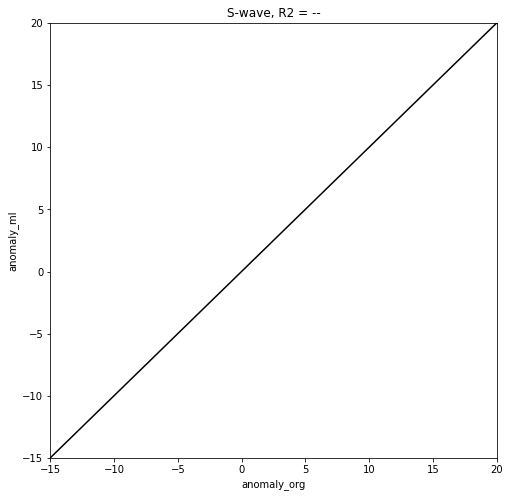

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_scatter(phase: str, gcarc_range: set, fidelity_func, org_constraint=lambda tb: pd.isnull(tb) | pd.notnull(tb), raw_prefix='updeANMO_shift_plot', ref_prefix='updeANMO_plot', x_axis='anomaly_org', y_axis='anomaly', mark_size=lambda r: 50*r**2):
    # table = pd.read_csv(f'test_plot_{phase.lower()}.csv')
    table_raw = pd.read_csv(f'{raw_prefix}_{phase.lower()}.csv')
    table_ref = pd.read_csv(f'{ref_prefix}_{phase.lower()}.csv')
    columns_joined = pd.DataFrame({'file_name': table_ref['file_name'].values, 'probability_ref': table_ref['probability'].values, 'anomaly_ref': table_ref['anomaly'].values})
    table = table_raw.merge(columns_joined, how='left', on='file_name')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.75) & (table['gcarc'] > 85) & (table['gcarc'] < 100)]
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['probability_ref'] > 0.7)  & (abs(table['anomaly']-table['anomaly_ref']) < 5) & (table['gcarc'] > 80)]
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['gcarc'] > 85) & (table['gcarc'] < 95)]
    # fidelity = table['probability'] - alpha*(abs(table['anomaly']-table['anomaly_ref']))/table['anomaly'].std()*table['probability_ref']
    fidelity = fidelity_func(picker1_prob=table['probability'],
                             picker1_anomaly=table['anomaly'],
                             picker2_prob=table['probability_ref'],
                             picker2_anomaly=table['anomaly_ref'])
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability']-table['probability_ref']<0.4) & (fidelity > beta) & (table['gcarc'] > 80) & (table['gcarc'] < 90)]
    scatter_table = table[(org_constraint(table['anomaly_org'])) & (fidelity > 0) & (table['gcarc'] > gcarc_range[0]) & (table['gcarc'] < gcarc_range[1])]
    print(f"{len(scatter_table)} points fit the conditions")
    x = scatter_table[x_axis].values
    y = scatter_table[y_axis].values
    r = scatter_table['probability'].values

    # print(x)
    cc = np.ma.corrcoef(np.ma.masked_invalid(x),np.ma.masked_invalid(y))

    plt.figure(figsize=(8,8))
    plt.plot(([-20,20]),([-20,20]),'k')
    plt.scatter(x[:],y[:],s=mark_size(r[:]))

    plt.xlim(-15,20)
    plt.ylim(-15,20)
    plt.xlabel(x_axis)
    plt.ylabel('anomaly_ml' if y_axis == 'anomaly' else y_axis)
    plt.title(f"{phase.upper()}-wave, R2 = {cc[0,1]:.4f}")
    plt.show()

    return scatter_table

def fidelity(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly):
    alpha=2; beta=0.3
    return picker1_prob - alpha*(abs(picker1_anomaly-picker2_anomaly))/picker1_anomaly.std()*picker2_prob - beta
    # alpha=2; beta=0.6
    # return picker1_prob - beta
    # alpha=2; beta=0.7
    # return picker1_prob - beta
    # alpha=1; beta=0.7
    # return picker1_prob - beta

def fidelity_rev(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.1#0.72
def fidelity_p(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.7
def fidelity_rev_p(picker1_prob, picker1_anomaly, picker2_prob, picker2_anomaly): return picker1_prob - 0.5#0.75

# scatter_table = plot_scatter('s', (85,95), fidelity, x_axis='anomaly_org')
# scatter_table = plot_scatter('s', (75,85), fidelity, x_axis='anomaly_org')

# scatter_table = plot_scatter('s', (85,95), fidelity, x_axis='anomaly_org')
# scatter_table = plot_scatter('s', (35,195), fidelity_rev, x_axis='anomaly_org', raw_prefix='updeANMO_shift2_plot', ref_prefix='updeANMO_shift_plot')
# scatter_table = plot_scatter('s', (35,195), fidelity, x_axis='anomaly_org')
# scatter_table = plot_scatter('s', (35,195), fidelity_rev, x_axis='anomaly_org', raw_prefix='updeANMO_shift5_plot', ref_prefix='updeANMO_shift_plot')
# scatter_table = plot_scatter('p', (35,195), fidelity_p, x_axis='anomaly_org')
# scatter_table = plot_scatter('p', (35,195), fidelity_rev_p, x_axis='anomaly_org', raw_prefix='updeANMO_shift5_plot', ref_prefix='updeANMO_shift_plot')
# scatter_table = plot_scatter('s', (35,195), fidelity_rev, x_axis='anomaly_org', raw_prefix='updeANMO_shift5_fedbp_plot', ref_prefix='updeANMO_shift_plot')
# scatter_table = plot_scatter('s', (35,195), fidelity_rev, x_axis='anomaly_org', raw_prefix='updeANMO_shift5_catalog_plot', ref_prefix='updeANMO_shift_plot')
scatter_table = plot_scatter('s', (35,195), fidelity_rev, x_axis='anomaly_org', raw_prefix='updeANMO_shift5_catalog3_plot', ref_prefix='updeANMO_shift_plot')
# scatter_table = plot_scatter('p', (35,195), fidelity_rev_p, x_axis='anomaly_org', raw_prefix='updeANMO_shift5_fedbp_plot', ref_prefix='updeANMO_shift_plot')

plt.show()

<AxesSubplot:>

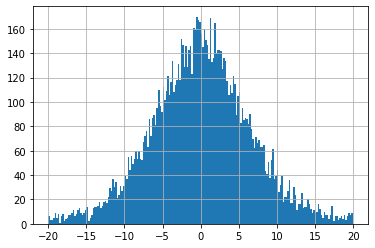

In [17]:
x = scatter_table['anomaly_org'].values
y = scatter_table['anomaly'].values
r = scatter_table['probability'].values

yy = pd.Series(y)
yy.hist(bins=200)

<AxesSubplot:>

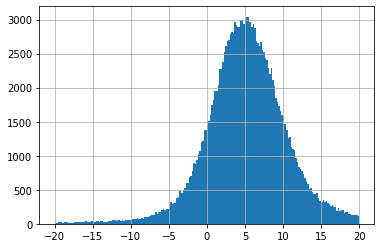

In [11]:
x = scatter_table['anomaly_org'].values
y = scatter_table['anomaly'].values
r = scatter_table['probability'].values

yy = pd.Series(y)
yy.hist(bins=200)

<AxesSubplot:>

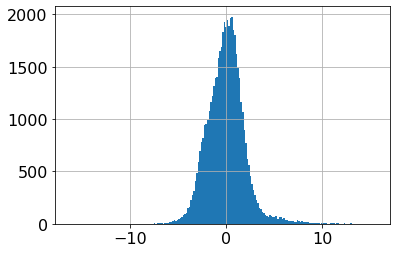

In [84]:
picking_error = pd.Series(y-x)
picking_error.hist(bins=200)

In [27]:
bugs_table = scatter_table[(scatter_table['anomaly'] < -15)]
bugs_table.to_csv('./hmsl_bugs_pred/neg15sec.csv')

In [13]:
import pandas as pd
from cmcrameri import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

table = pd.read_csv('test_plot_p.csv')
scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7)]
lons = scatter_table['turning_lon'].values
lats = scatter_table['turning_lat'].values
c = scatter_table['anomaly'].values
r = scatter_table['probability'].values

m = Basemap(projection='moll',lon_0=-180,resolution='c')
# m.scatter(lon[:200],lat[:200],s=50*r[:200]**4)
# plt.plot(x, y)
# m.drawcoastlines
# plt.show()()

inf inf


In [15]:
import os
import csv
import shutil
bug_table = table[(table['anomaly'] < -10) & (table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['gcarc'] > 85)]
src_hdfs = "./hmsl_hdfs"
bug_hdfs = "./hmsl_bugs"
# bug_table
for index, item in bug_table.iterrows():
   station_name = item['file_name'].split('_')[0]
   hdf5_src_name = f"{src_hdfs}/{station_name}.hdf5"
   hdf5_dst_name = f"{bug_hdfs}/{station_name}.hdf5"
   if not os.path.exists(hdf5_dst_name):
        shutil.copyfile(hdf5_src_name, hdf5_dst_name)
   if not os.path.exists(f'{bug_hdfs}/{station_name}.csv'):
        csvfile = open(f'{bug_hdfs}/{station_name}.csv', 'w')
     #    with pd.read_csv(f"{src_hdfs}/{station_name}.csv") as ref_table:
        for _, ref_item in ref_table[ref_table['trace_name']==item['file_name']].iterrows():
          starttime = ref_item['start_time']
        output_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        output_writer.writerow(['trace_name', 'start_time'])
        output_writer.writerow([item['file_name'], starttime])

   else:
        csvfile = open(f'{bug_hdfs}/{station_name}.csv', 'a')
        output_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        ref_table = pd.read_csv(f"{src_hdfs}/{station_name}.csv")
        for _, ref_item in ref_table[ref_table['trace_name']==item['file_name']].iterrows():
          starttime = ref_item['start_time']
        output_dataset = pd.read_csv(f'{bug_hdfs}/{station_name}.csv')
        if len(output_dataset[output_dataset['trace_name']==item['file_name']]) == 0:
          output_writer.writerow([item['file_name'], starttime])
    


1145 points fit the conditions


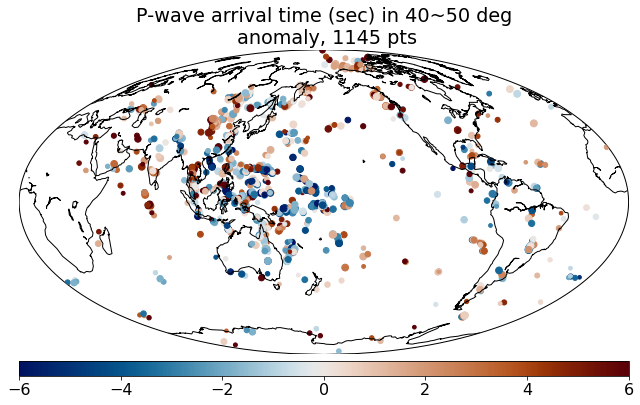

In [50]:
import numpy as np
import pandas as pd
from cmcrameri import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
# plt.style.use('dark_background')
# map = Basemap(projection='ortho', 
#               lat_0=0, lon_0=0)
map = Basemap(projection='moll',lon_0=-180,resolution='c')
map.drawmapboundary(fill_color='white')
# map.drawmapboundary(fill_color='aqua')
# map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()


def plot_depthslice(phase: str, value: str, gcarc_range: set, fidelity_func, org_constraint=lambda tb: pd.isnull(tb) | pd.notnull(tb), raw_prefix='updeANMO_shift_plot', ref_prefix='updeANMO_plot', mark_size=lambda r: 50*r**2):
    # table = pd.read_csv('test_plot_p.csv')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['gcarc'] >85)]
    # table = pd.read_csv('test_plot_s.csv')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.8) & (table['gcarc'] > 85)]
    # alpha = 0.75
    table_raw = pd.read_csv(f'{raw_prefix}_{phase.lower()}.csv')
    table_ref = pd.read_csv(f'{ref_prefix}_{phase.lower()}.csv')
    columns_joined = pd.DataFrame({'file_name': table_ref['file_name'].values, 'probability_ref': table_ref['probability'].values, 'anomaly_ref': table_ref['anomaly'].values})
    table = table_raw.merge(columns_joined, how='left', on='file_name')
    fidelity = fidelity_func(picker1_prob=table['probability'],
                             picker1_anomaly=table['anomaly'],
                             picker2_prob=table['probability_ref'],
                             picker2_anomaly=table['anomaly_ref'])
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['probability_ref'] > 0.7)  & (abs(table['anomaly']-table['anomaly_ref']) < 5) & (table['gcarc'] > 80)]
    # scatter_table = table[(table['probability'] > 0.7) & (table['gcarc'] < 95) & (table['gcarc'] > 85)] ##p
    if value=='anomaly_org': fidelity = (fidelity+1)
    scatter_table = table[(org_constraint(table['anomaly_org'])) & (fidelity > 0) & (table['gcarc'] > gcarc_range[0]) & (table['gcarc'] < gcarc_range[1])]
    # fidelity = table['probability'] - alpha*(abs(table['anomaly']-table['anomaly_ref']))/table['anomaly'].std()*table['probability_ref']
    # scatter_table = table[(table['anomaly_org'].isnull()) & (fidelity > 0) & (table['gcarc'] > 80)]
    # table = pd.read_csv(f'test_plot_{phase.lower()}.csv')
    # table = pd.read_csv(f'updeANMO_shift_plot_{phase.lower()}.csv')
    # scatter_table = table[(table['anomaly_org'].notnull()) & (table['probability'] > 0.7) & (table['gcarc'] > 80)]

    lons = scatter_table['turning_lon'].values[:]
    lats = scatter_table['turning_lat'].values[:]
    prob = scatter_table['probability'].values[:]
    anomaly = scatter_table[value].values[:]
    print(f"{sum(scatter_table[value].notnull())} points fit the conditions")
    # print(type(anomaly[0]))

    x, y = map(lons, lats)
    anomaly -= np.nanmean(anomaly)

    map.scatter(x, y, c=anomaly, s=mark_size(prob), marker='o', cmap=cm.vik)
    # map.scatter(x, y, c=anomaly, marker='o', cmap=cm.vik)
    map.colorbar(location='bottom')
    colorscale = 15 if phase.lower() == 's' else 6
    plt.clim(-colorscale, colorscale)
    plt.title(f'{phase.upper()}-wave arrival time (sec) in {gcarc_range[0]}~{gcarc_range[1]} deg\n {value}, {sum(scatter_table[value].notnull())} pts')

# plot_depthslice('s', 'anomaly', (50,160), fidelity)
# plot_depthslice('s', 'anomaly', (85,90), fidelity_rev, raw_prefix='updeANMO_shift5_plot')
# plot_depthslice('p', 'anomaly', (90,100), fidelity_rev_p, raw_prefix='updeANMO_shift5_plot')
plot_depthslice('p', 'anomaly', (40,50), fidelity_rev_p, raw_prefix='updeANMO_shift5_catalog3_plot')
# plot_depthslice('s', 'anomaly', (90,110), fidelity_rev, raw_prefix='updeANMO_shift5_plot')
# plot_depthslice('s', 'anomaly', (90,110), fidelity_rev, raw_prefix='updeANMO_shift5_catalog3_plot')
plt.rcParams["font.size"] = 16
plt.show()

In [111]:
p = GeoPoint.midpoint(_, GeoPoint(lat=-20.088,  lon=146.254), GeoPoint(lat=51.600, lon=159.330))
p.longitude, p.latitude

({'rad': 2.6433687688064653, 'deg': 151.45387414930312},
 {'rad': 0.27663230791462334, 'deg': 15.849863720471358})

In [19]:
import h5py
import numpy as np
import pandas as pd

trace_name = "ANMO_IU_LH_1992-07-18T21:18:57.500Z"
dd = pd.read_csv(f"hmsl_pred/{trace_name.split('_')[0]}_outputs/X_prediction_results.csv")

spt = []; sst = []
matches = dd[dd['file_name']==trace_name]
# if matches[0]
with h5py.File('hmsl_hdfs/ANMO.hdf5', 'r') as f:
    dataset = f[f"/data/{trace_name}"]
    data = dataset[...]
    evi = dataset.attrs["trace_name"]
    # s_arrival_time = dataset.attrs["snr_db"]
# data[:,0]
evi
# s_arrival_time

'ANMO_IU_LH_1992-07-18T21:18:57.500Z'